In [16]:
from collections import Counter, defaultdict
from typing import List, Dict, Literal, Union

import re
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [17]:
ds = load_dataset("UniverseTBD/arxiv-abstracts-large")
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed'],
        num_rows: 2292057
    })
})

In [18]:
for i in range(3):
    print(f"Example {i + 1}:")
    print(ds["train"][i]["abstract"])
    print(ds["train"][i]["categories"])
    print("---" * 20)

Example 1:
  A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
that enhanced sensitivity to the signal can be obtained with judicious
selection of events.

hep-p

In [19]:
all_categories = ds["train"]["categories"]
categories_set = set()

# Collect unique labels
for category in all_categories:
    parts = category.split(" ")
    for part in parts:
        topic = part.split(".")[0]
        categories_set.add(topic)

# Sort the labels and print them
sorted_categories = sorted(list(categories_set), key=lambda x: x.lower())
print(f"There are {len(sorted_categories)} unique primary categories in the dataset:")
for category in sorted_categories:
    print(category)

There are 38 unique primary categories in the dataset:
acc-phys
adap-org
alg-geom
ao-sci
astro-ph
atom-ph
bayes-an
chao-dyn
chem-ph
cmp-lg
comp-gas
cond-mat
cs
dg-ga
econ
eess
funct-an
gr-qc
hep-ex
hep-lat
hep-ph
hep-th
math
math-ph
mtrl-th
nlin
nucl-ex
nucl-th
patt-sol
physics
plasm-ph
q-alg
q-bio
q-fin
quant-ph
solv-int
stat
supr-con


In [20]:
# load samples with single label beloging to specific categories
samples = []
CATEGORIES_TO_SELECT = ["astro-ph", "cond-mat", "cs", "math", "physics"]
for s in ds["train"]:
    if len(s["categories"].split(" ")) != 1:
        continue

    cur_category = s["categories"].strip().split(".")[0]
    if cur_category not in CATEGORIES_TO_SELECT:
        continue
    samples.append(s)

    if len(samples) >= 1000:
        break

print(f"Number of samples: {len(samples)}")

Number of samples: 1000


Tiền xử lý dữ liệu

In [21]:
preprocessed_samples = []
for s in samples:
    abstract = s["abstract"]

    # Remove \n
    abstract = abstract.strip().replace("\n", " ")

    # Remove special character
    abstract = re.sub(r"[^\w\s]", "", abstract)

    # Remove digits
    abstract = re.sub(r"\d+", "", abstract)

    # Remove extra spaces
    abstract = re.sub(r"\s+", " ", abstract).strip()

    # Convert to lower case
    abstract = abstract.lower()

    # for the label, only keep the first part
    parts = s["categories"].split(" ")
    category = parts[0].split(".")[0]

    preprocessed_samples.append({"text": abstract, "label": category})

In [22]:
print(preprocessed_samples)

[{'text': 'the evolution of earthmoon system is described by the dark matter field fluid model proposed in the meeting of division of particle and field american physical society the current behavior of the earthmoon system agrees with this model very well and the general pattern of the evolution of the moonearth system described by this model agrees with geological and fossil evidence the closest distance of the moon to earth was about km at billion years ago which is far beyond the roches limit the result suggests that the tidal friction may not be the primary cause for the evolution of the earthmoon system the average dark matter field fluid constant derived from earthmoon system data is x sm this model predicts that the marss rotation is also slowing with the angular acceleration rate about x rad s', 'label': 'physics'}, {'text': 'we show that a determinant of stirling cycle numbers counts unlabeled acyclic singlesource automata the proof involves a bijection from these automata to

In [23]:
label_to_id = {label: i for i, label in enumerate(sorted_categories)}
id_to_label = {i: label for i, label in enumerate(sorted_categories)}

# Print label to ID mapping
print("Label to ID mapping:")
for label, id_ in label_to_id.items():
    print(f"{label} ---> {id_}")

Label to ID mapping:
acc-phys ---> 0
adap-org ---> 1
alg-geom ---> 2
ao-sci ---> 3
astro-ph ---> 4
atom-ph ---> 5
bayes-an ---> 6
chao-dyn ---> 7
chem-ph ---> 8
cmp-lg ---> 9
comp-gas ---> 10
cond-mat ---> 11
cs ---> 12
dg-ga ---> 13
econ ---> 14
eess ---> 15
funct-an ---> 16
gr-qc ---> 17
hep-ex ---> 18
hep-lat ---> 19
hep-ph ---> 20
hep-th ---> 21
math ---> 22
math-ph ---> 23
mtrl-th ---> 24
nlin ---> 25
nucl-ex ---> 26
nucl-th ---> 27
patt-sol ---> 28
physics ---> 29
plasm-ph ---> 30
q-alg ---> 31
q-bio ---> 32
q-fin ---> 33
quant-ph ---> 34
solv-int ---> 35
stat ---> 36
supr-con ---> 37


In [ ]:
print(len(id_to_label))


38


In [24]:
X_full = [sample["text"] for sample in preprocessed_samples]
y_full = [label_to_id[sample["label"]] for sample in preprocessed_samples]

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 800
Test samples: 200


Mã hóa văn bản

In [25]:
# Dùng bag of words
docs = [
    "I am going to school to study for the final exam.",
    "The weather is nice today and I feel happy.",
    "I love programming in Python and exploring new libraries.",
    "Data science is an exciting field with many opportunities.",
]

bow = CountVectorizer()
vectors = bow.fit_transform(docs)
X_train_vectors = bow.fit_transform(X_train)

for i, vec in enumerate(vectors):
    print(f"Document {i + 1}: {vec.toarray()}")

Document 1: [[1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 2 0 0 0]]
Document 2: [[0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0]]
Document 3: [[0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0]]
Document 4: [[0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1]]


In [26]:
# Dùng TF-IDF
vectorizer = TfidfVectorizer()
tfidf_vectors = vectorizer.fit_transform(docs)

for i, vec in enumerate(tfidf_vectors):
    print(f"TF-IDF for Document {i + 1}")
    print(vec.toarray())

TF-IDF for Document 1
[[0.29333722 0.         0.         0.         0.29333722 0.
  0.         0.         0.         0.29333722 0.29333722 0.29333722
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.29333722
  0.         0.29333722 0.23127044 0.58667444 0.         0.
  0.        ]]
TF-IDF for Document 2
[[0.         0.         0.30091213 0.         0.         0.
  0.         0.38166888 0.         0.         0.         0.
  0.38166888 0.         0.30091213 0.         0.         0.
  0.         0.38166888 0.         0.         0.         0.
  0.         0.         0.30091213 0.         0.38166888 0.38166888
  0.        ]]
TF-IDF for Document 3
[[0.         0.         0.2855815  0.         0.         0.
  0.36222393 0.         0.         0.         0.         0.
  0.         0.36222393 0.         0.36222393 0.36222393 0.
  0.36222393 0.         0.         0.36222393 0.36222393 0.
  0.         0.         0.         0.   

Sentence Embeddings

In [27]:
# Xây dựng EmbeddingVectorizer để mã hóa văn bản
class EmbeddingVetorizer:
    def __init__(
        self, model_name: str = "intfloat/multilingual-e5-base", normalize: bool = True
    ):
        self.model = SentenceTransformer(model_name)
        self.normalize = normalize

    def _format_inputs(
        self, texts: List[str], mode: Literal["query", "passage"]
    ) -> List[str]:
        if mode not in {"query", "passage"}:
            raise ValueError("Mode must be either 'query' or 'passage")
        return [f"{mode}:{text.strip()}" for text in texts]

    def transform(
        self, texts: List[str], mode: Literal["query", "passage"] = "query"
    ) -> List[List[float]]:
        if mode == "raw":
            inputs = texts
        else:
            inputs = self._format_inputs(texts, mode)

        embeddings = self.model.encode(inputs, normalize_embeddings=self.normalize)
        return embeddings.tolist()

    def transform_numpy(
        self, texts: List[str], mode: Literal["query", "passage"] = "query"
    ) -> np.ndarray:
        return np.array(self.transform(texts, mode=mode))


vectorizer = EmbeddingVetorizer()
embeddings = vectorizer.transform(docs)

for i, emb in enumerate(embeddings):
    print(f"Embedding for Document {i + 1}:")
    print(emb[:3])

Embedding for Document 1:
[-0.014451595954596996, 0.030864819884300232, -0.016362695023417473]
Embedding for Document 2:
[0.01345460582524538, 0.033343009650707245, -0.023733537644147873]
Embedding for Document 3:
[0.01301681250333786, 0.0387515053153038, -0.023786339908838272]
Embedding for Document 4:
[0.008124035783112049, 0.05072278901934624, -0.02961552143096924]


Khai báo và khởi tạo các vectorizers

In [28]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

embedding_vectorizer = EmbeddingVetorizer()
X_train_embeddings = embedding_vectorizer.transform(X_train)
X_test_embeddings = embedding_vectorizer.transform(X_test)

# Convert all to numpy arrays for consistency
X_train_bow, X_test_bow = (
    np.array(X_train_bow.toarray()),
    np.array(X_test_bow.toarray()),
)
X_train_tfidf, X_test_tfidf = (
    np.array(X_train_tfidf.toarray()),
    np.array(X_test_tfidf.toarray()),
)
X_train_embeddings, X_test_embeddings = (
    np.array(X_train_embeddings),
    np.array(X_test_embeddings),
)

# Print shapes of the transformed datasets
print(f"Shape of X_train_bow: {X_train_bow.shape}")
print(f"Shape of X_test_bow: {X_test_bow.shape}\n")
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}\n")
print(f"Shape of X_train_embeddings: {X_train_embeddings.shape}")
print(f"Shape of X_test_embeddings: {X_test_embeddings.shape}\n")


Shape of X_train_bow: (800, 10373)
Shape of X_test_bow: (200, 10373)

Shape of X_train_tfidf: (800, 10373)
Shape of X_test_tfidf: (200, 10373)

Shape of X_train_embeddings: (800, 768)
Shape of X_test_embeddings: (200, 768)



Hàm train_and_test_kmeans để huấn luyện mô hình KMeans

In [53]:
def train_and_test_kmeans(X_train, y_train, X_test, y_test, n_clusters: int):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
    cluster_ids = kmeans.fit_predict(X_train)

    # Assign label to clusters
    cluster_to_label = {}
    for cluster_id in set(cluster_ids):
        # Get all labels in this cluster
        labels_in_cluster = [
            y_train[i] for i in range(len(y_train)) if cluster_ids[i] == cluster_id
        ]
        most_common_label = Counter(labels_in_cluster).most_common(1)[0][0]
        cluster_to_label[cluster_id] = most_common_label

    # Predict labels for test set
    test_cluster_ids = kmeans.predict(X_test)
    y_pred = [cluster_to_label[cluster_id] for cluster_id in test_cluster_ids]
    accuracy = accuracy_score(y_test, y_pred)

    report = classification_report(
        y_test,
        y_pred,
        labels=sorted_categories,
        target_names=[id_to_label[i] for i in range(len(id_to_label))],
        output_dict=True,
        zero_division=0
    )

    return y_pred, accuracy, report

In [54]:
# Train and test K-Means on different vectorize datasets
km_bow_labels, km_bow_accuracy, km_bow_report = train_and_test_kmeans(
    X_train_bow, y_train, X_test_bow, y_test, n_clusters=len(label_to_id)
)

km_tfidf_labels, km_tfidf_accuracy, km_tfidf_report = train_and_test_kmeans(
    X_train_tfidf, y_train, X_test_tfidf, y_test, n_clusters=len(label_to_id)
)

km_embeddings_labels, km_embeddings_accuracy, km_embeddings_report = (
    train_and_test_kmeans(
        X_train_embeddings,
        y_train,
        X_test_embeddings,
        y_test,
        n_clusters=len(label_to_id),
    )
)

print("Accuracy for K-Means:")
print(f"Bag of Words: {km_bow_accuracy:.4f}")
print(f"TF-IDF: {km_tfidf_accuracy:.4f}")
print(f"Embeddings: {km_embeddings_accuracy:.4f}")

Accuracy for K-Means:
Bag of Words: 0.5650
TF-IDF: 0.7650
Embeddings: 0.8700


Vẽ confusion matrix cho từng phương pháp mã hóa với hàm plot_confusion_matrix

In [48]:
def plot_confusion_matrix(y_true, y_pred, label_list, figure_name="Confusion Matrix",save_path=None):
    # Compute confusion matrix and normalize
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Map class indices to names
    labels = np.unique(y_true)
    if isinstance(label_list, dict):
        class_names = [label_list[i] for i in labels]
    else:
        class_names = [label_list[i] for i in labels]

    # Create annotations with raw + normalized values
    annotations = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            raw = cm[i,j]
            norm = cm_normalized[i,j]
            annotations[i,j]=f'{raw}\n({norm:.2f})'

    # Plot
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=annotations, fmt="", cmap="Blues", xticklabels=class_names, yticklabels=class_names,cbar=False, linewidths=1, linecolor="black")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(figure_name)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()

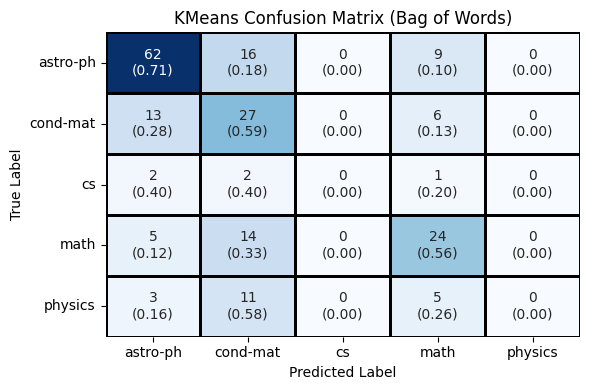

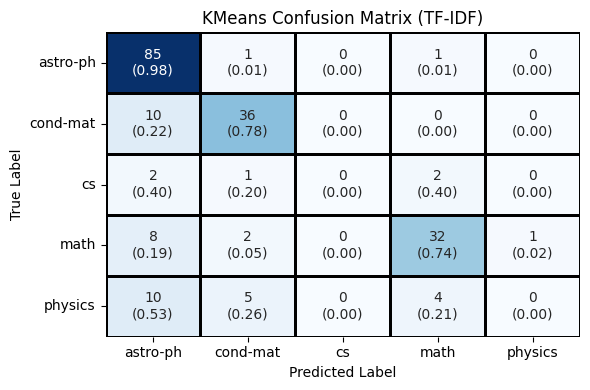

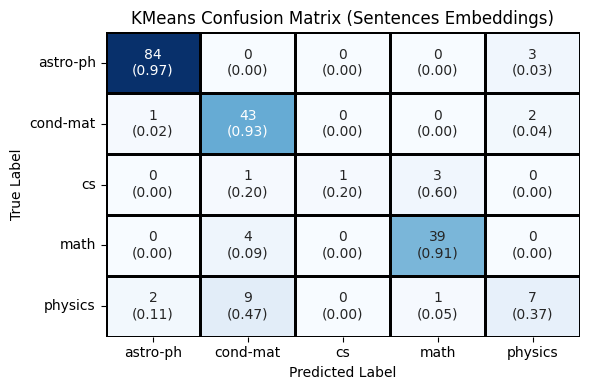

In [55]:
# Draw confusion matrixes
plot_confusion_matrix(y_test, km_bow_labels, sorted_categories, "KMeans Confusion Matrix (Bag of Words)")
plot_confusion_matrix(y_test, km_tfidf_labels, sorted_categories, "KMeans Confusion Matrix (TF-IDF)")
plot_confusion_matrix(y_test, km_embeddings_labels, sorted_categories, "KMeans Confusion Matrix (Sentences Embeddings)")
